In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_A.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [6]:
data_std.fillna(0, inplace= True)

In [7]:
Y = data_std['Coeff_A'] 
X = data_std.drop(['Coeff_A','Name'], axis=1)

### Using CV technique

RF
R2:  0.8942563088843241
RMSE:  0.3251825504477076
---------------------------------------
GB
R2:  0.8474170271810111
RMSE:  0.3906187051575857
---------------------------------------
LR
R2:  -3.8101967514623825
RMSE:  2.193216074959871
---------------------------------------
RR
R2:  -0.12918504014149468
RMSE:  1.062631187261834
---------------------------------------
LASSO
R2:  0.9027129855111254
RMSE:  0.3119086636964009
---------------------------------------
gpr1
R2:  0.49017038862648
RMSE:  0.7140235369884665
---------------------------------------
gpr2
R2:  0.9472376295038519
RMSE:  0.22970061056981994
---------------------------------------
gpr3
R2:  0.9516822533724986
RMSE:  0.21981298102592
---------------------------------------
gpr4
R2:  0.9517028140038968
RMSE:  0.21976620758456758
---------------------------------------
gpr5
R2:  0.9503632030446623
RMSE:  0.2227931708004932
---------------------------------------
gpr6
R2:  0.8800637916229233
RMSE:  0.34631807399712305
--

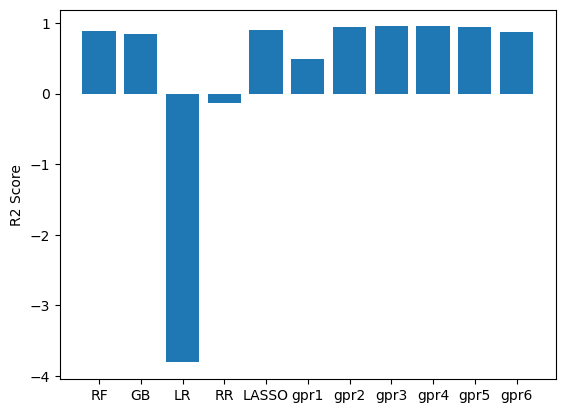

In [8]:
run_models()

## Feature selection


In [9]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  142.353080
26      X_EA  112.702665
14       X_Z  106.612941
34    X_Rvdw   86.120704
23    X_IEII   80.598055
4   mean_X2X   79.003498
32    A_Rvdw   56.376662
2   mean_A2X   55.191431
18     A_IEI   38.414491
30    A_ChiA   35.147717
9      E_coh   34.402479
44      B_Hf   18.081523
6    std_A2X   18.021854
27    A_ChiP   17.250853
7    std_B2X   16.580759
17       X_G   15.282633
38      B_MP   14.690246
11        OF   14.513522
36      B_Ra   13.703676
37      A_MP   13.495857
24      A_EA   11.836644
12       A_Z   11.590484
13       B_Z   11.204890
47   X_Kappa    9.959958
48     A_CvM    8.849576
45   A_Kappa    8.078728
46   B_Kappa    7.615863
43      X_MV    7.419386
42      B_MV    7.256271
50       A_B    5.603181


In [10]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA', 'E_coh', 'B_Hf',
       'std_A2X', 'A_ChiP', 'std_B2X', 'X_G', 'B_MP', 'OF', 'B_Ra',
       'A_MP', 'A_EA', 'A_Z', 'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa',
       'B_Kappa', 'X_MV', 'B_MV', 'A_B', 'std_A2B', 'A_G', 'B_Rho',
       'std_X2X', 'B_CvM', 'B_EA', 'X_IEI', 'B_Rvdw', 'TF', 'B_Rc'],
      dtype=object)

In [11]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8997679541661592
RMSE:  0.31659445009955683
---------------------------------------
GB
R2:  0.859045762829973
RMSE:  0.37543872625240327
---------------------------------------
LR
R2:  -1.0376988331680765
RMSE:  1.4274798888839297
---------------------------------------
RR
R2:  0.49764774650828725
RMSE:  0.7087681239246816
---------------------------------------
LASSO
R2:  0.9077274129814878
RMSE:  0.3037640318051368
---------------------------------------
gpr1
R2:  0.7984215108499154
RMSE:  0.4489749315385933
---------------------------------------
gpr2
R2:  0.9555001712365926
RMSE:  0.2109498252272503
---------------------------------------
gpr3
R2:  0.9584370731973139
RMSE:  0.2038698771341322
---------------------------------------
gpr4
R2:  0.9584370701137203
RMSE:  0.20386988469678327
---------------------------------------
gpr5
R2:  0.9567311862582761
RMSE:  0.2080115711726727
---------------------------------------
gpr6
R2:  0.9030985311849934
RMSE:  0.311290007573334

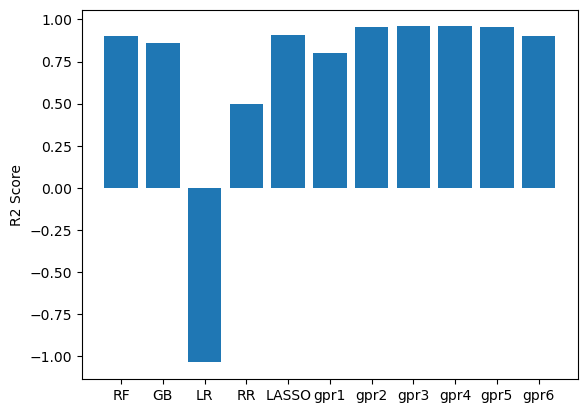

In [12]:
run_models()

In [13]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA', 'E_coh', 'B_Hf',
       'std_A2X', 'A_ChiP', 'std_B2X', 'X_G', 'B_MP', 'OF', 'B_Ra',
       'A_MP', 'A_EA', 'A_Z', 'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa',
       'B_Kappa', 'X_MV', 'B_MV', 'A_B'], dtype=object)

In [14]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9030731798830216
RMSE:  0.31133072465945016
---------------------------------------
GB
R2:  0.8649425322623823
RMSE:  0.36750165678213986
---------------------------------------
LR
R2:  0.7739674021411092
RMSE:  0.47542885677974034
---------------------------------------
RR
R2:  0.7761629736017426
RMSE:  0.4731141790289711
---------------------------------------
LASSO
R2:  0.8970920707401726
RMSE:  0.32079265773989807
---------------------------------------
gpr1
R2:  0.8507139856697536
RMSE:  0.38637548360402774
---------------------------------------
gpr2
R2:  0.9368997330286468
RMSE:  0.25119766513913544
---------------------------------------
gpr3
R2:  0.9480867668959682
RMSE:  0.2278447565866545
---------------------------------------
gpr4
R2:  0.9480867684807274
RMSE:  0.22784475310893745
---------------------------------------
gpr5
R2:  0.9498139661846552
RMSE:  0.22402239578967284
---------------------------------------
gpr6
R2:  0.9161089263441969
RMSE:  0.28963955816

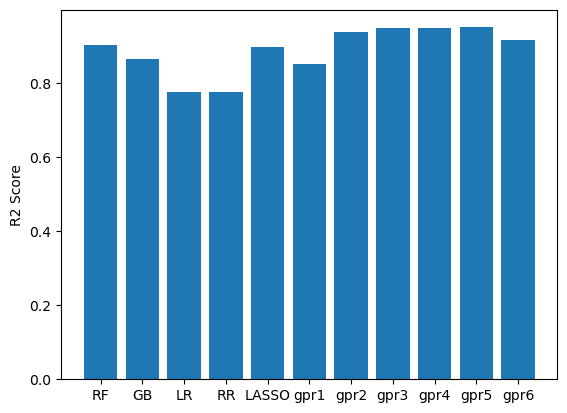

In [15]:
run_models()

In [16]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA', 'E_coh', 'B_Hf',
       'std_A2X', 'A_ChiP', 'std_B2X', 'X_G', 'B_MP', 'OF', 'B_Ra',
       'A_MP'], dtype=object)

In [17]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8816853869353267
RMSE:  0.34396891293352844
---------------------------------------
GB
R2:  0.8186906537144922
RMSE:  0.4258043521213795
---------------------------------------
LR
R2:  0.8201938867165827
RMSE:  0.42403550946049007
---------------------------------------
RR
R2:  0.8206349698654622
RMSE:  0.42351508843787106
---------------------------------------
LASSO
R2:  0.8781490090818238
RMSE:  0.34907161287932914
---------------------------------------
gpr1
R2:  0.8565828785837779
RMSE:  0.3787045304933942
---------------------------------------
gpr2
R2:  0.9240341549265867
RMSE:  0.27561902161028967
---------------------------------------
gpr3
R2:  0.8093968647305001
RMSE:  0.4365811897797475
---------------------------------------
gpr4
R2:  0.923184988571201
RMSE:  0.2771552118016167
---------------------------------------
gpr5
R2:  0.9329967516960336
RMSE:  0.25884985668137134
---------------------------------------
gpr6
R2:  0.9275838398721286
RMSE:  0.26910250858710

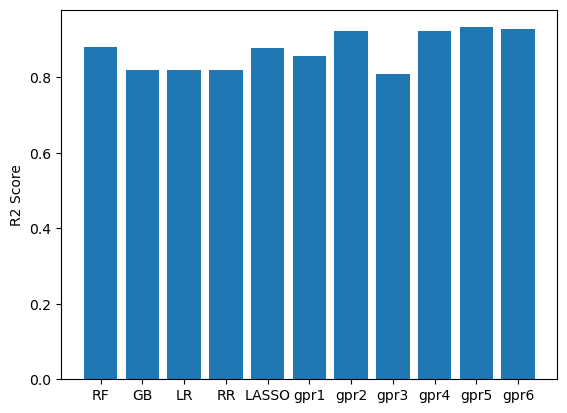

In [18]:
run_models()

In [19]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'mean_A2X', 'A_IEI', 'A_ChiA'], dtype=object)

In [20]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8659780243137765
RMSE:  0.3660901196238755
---------------------------------------
GB
R2:  0.8191097723770643
RMSE:  0.4253119180353823
---------------------------------------
LR
R2:  0.8631840751956871
RMSE:  0.3698863674215542
---------------------------------------
RR
R2:  0.8632269190071513
RMSE:  0.36982844805781057
---------------------------------------
LASSO
R2:  0.8681956453847558
RMSE:  0.3630486945510812
---------------------------------------
gpr1
R2:  0.8730252929036139
RMSE:  0.3563351050575653
---------------------------------------
gpr2
R2:  0.8691844064372551
RMSE:  0.3616843839077724
---------------------------------------
gpr3
R2:  0.42511006524242845
RMSE:  0.7582149660601349
---------------------------------------
gpr4
R2:  0.464395636057227
RMSE:  0.7318499599936951
---------------------------------------
gpr5
R2:  0.8554324002279785
RMSE:  0.38022046206381566
---------------------------------------
gpr6
R2:  0.8665315312575935
RMSE:  0.3653333665878419


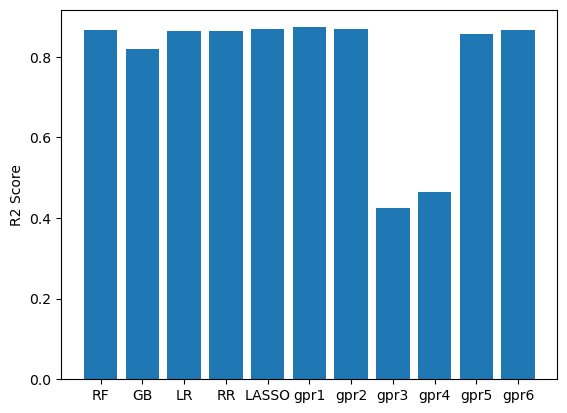

In [21]:
run_models()

# Min-Max scaling

In [22]:
data_mm = pd.read_csv('scaled_minmax_Coeff_A.csv', encoding='cp1252')

In [23]:
data_mm.fillna(0, inplace= True)

In [24]:
Y = data_mm['Coeff_A'] 
X = data_mm.drop(['Coeff_A','Name'], axis=1)

### Using CV technique

RF
R2:  0.9038011378999172
RMSE:  0.0837339020622228
---------------------------------------
GB
R2:  0.84967037863887
RMSE:  0.10467395755118179
---------------------------------------
LR
R2:  -5.30473593261072
RMSE:  0.6778753057064372
---------------------------------------
RR
R2:  0.7663727616415736
RMSE:  0.13049026115930848
---------------------------------------
LASSO
R2:  0.8330080544028047
RMSE:  0.11032250767385846
---------------------------------------
gpr1
R2:  0.7323284011846536
RMSE:  0.13967462342630552
---------------------------------------
gpr2
R2:  0.9534065348508163
RMSE:  0.05827454183147076
---------------------------------------
gpr3
R2:  0.9563958936016743
RMSE:  0.056374156655938416
---------------------------------------
gpr4
R2:  0.956395893549201
RMSE:  0.05637415668985882
---------------------------------------
gpr5
R2:  0.9581595277775274
RMSE:  0.05522232039456448
---------------------------------------
gpr6
R2:  0.9129573250677359
RMSE:  0.07964939422883

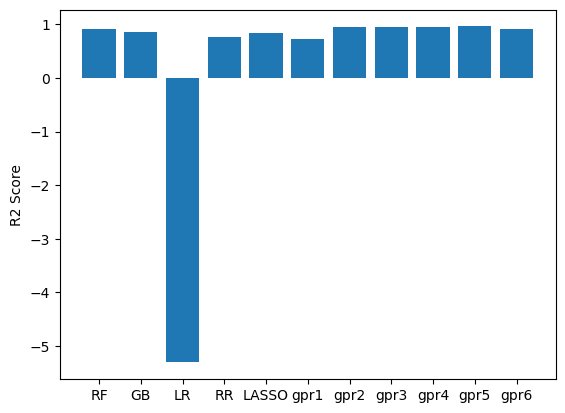

In [25]:
run_models()

## Feature selection


In [26]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  142.353080
26      X_EA  112.702665
14       X_Z  106.612941
34    X_Rvdw   86.120704
4   mean_X2X   79.003498
32    A_Rvdw   56.376662
2   mean_A2X   55.191431
18     A_IEI   38.414491
9      E_coh   34.402479
30    A_ChiA   33.512107
23    X_IEII   19.080411
44      B_Hf   18.081523
6    std_A2X   18.021854
27    A_ChiP   17.250853
7    std_B2X   16.580759
17       X_G   15.282633
38      B_MP   14.690246
11        OF   14.513522
36      B_Ra   13.703676
37      A_MP   13.495857
24      A_EA   11.836644
12       A_Z   11.590484
41     X_Rho   11.571776
13       B_Z   11.204890
47   X_Kappa    9.959958
48     A_CvM    8.849576
45   A_Kappa    8.078728
31    B_ChiA    7.713379
46   B_Kappa    7.615863
43      X_MV    7.419386


In [27]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'B_Hf',
       'std_A2X', 'A_ChiP', 'std_B2X', 'X_G', 'B_MP', 'OF', 'B_Ra',
       'A_MP', 'A_EA', 'A_Z', 'X_Rho', 'B_Z', 'X_Kappa', 'A_CvM',
       'A_Kappa', 'B_ChiA', 'B_Kappa', 'X_MV', 'B_MV', 'A_B', 'std_A2B',
       'A_G', 'std_X2X', 'B_CvM', 'B_Rho', 'B_EA', 'X_IEI', 'B_Rvdw'],
      dtype=object)

In [28]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9017855494028253
RMSE:  0.08460656407429427
---------------------------------------
GB
R2:  0.8572459811574603
RMSE:  0.10200243382849881
---------------------------------------
LR
R2:  -0.03784715163092223
RMSE:  0.2750318952165235
---------------------------------------
RR
R2:  0.8388457285780495
RMSE:  0.10837703695757059
---------------------------------------
LASSO
R2:  0.8330132712163163
RMSE:  0.11032078442774146
---------------------------------------
gpr1
R2:  0.7559125254906788
RMSE:  0.13337950754194247
---------------------------------------
gpr2
R2:  0.9496614090019874
RMSE:  0.06057129937957502
---------------------------------------
gpr3
R2:  0.9491407104000359
RMSE:  0.0608837659100095
---------------------------------------
gpr4
R2:  0.9491407060447595
RMSE:  0.06088376851686488
---------------------------------------
gpr5
R2:  0.9551701809325958
RMSE:  0.0571610049684827
---------------------------------------
gpr6
R2:  0.923210266688361
RMSE:  0.07481142759

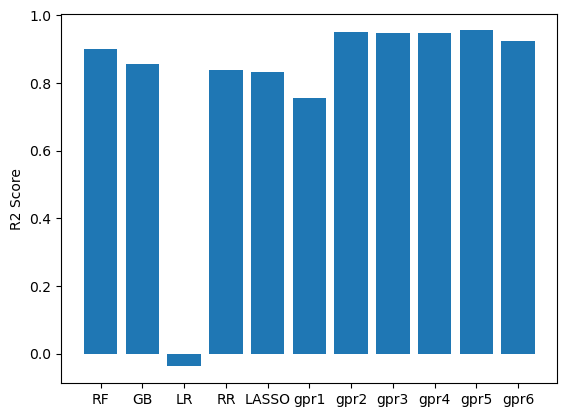

In [29]:
run_models()

In [30]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'B_Hf',
       'std_A2X', 'A_ChiP', 'std_B2X', 'X_G', 'B_MP', 'OF', 'B_Ra',
       'A_MP', 'A_EA', 'A_Z', 'X_Rho', 'B_Z', 'X_Kappa', 'A_CvM',
       'A_Kappa', 'B_ChiA', 'B_Kappa', 'X_MV'], dtype=object)

In [31]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9035568205834625
RMSE:  0.08384016459560825
---------------------------------------
GB
R2:  0.8751425033275478
RMSE:  0.09539457429947348
---------------------------------------
LR
R2:  0.7236830270400261
RMSE:  0.1419123343524651
---------------------------------------
RR
R2:  0.8092300011835003
RMSE:  0.11791563691312029
---------------------------------------
LASSO
R2:  0.8330132448292316
RMSE:  0.11032079314413407
---------------------------------------
gpr1
R2:  0.8269795068491146
RMSE:  0.11229621939919927
---------------------------------------
gpr2
R2:  0.9418002581124967
RMSE:  0.06512937220396743
---------------------------------------
gpr3
R2:  0.9416992466896271
RMSE:  0.06518586694323632
---------------------------------------
gpr4
R2:  0.9416992476338059
RMSE:  0.0651858664153949
---------------------------------------
gpr5
R2:  0.9499222052383294
RMSE:  0.06041419049053012
---------------------------------------
gpr6
R2:  0.9277102842410059
RMSE:  0.07258629362

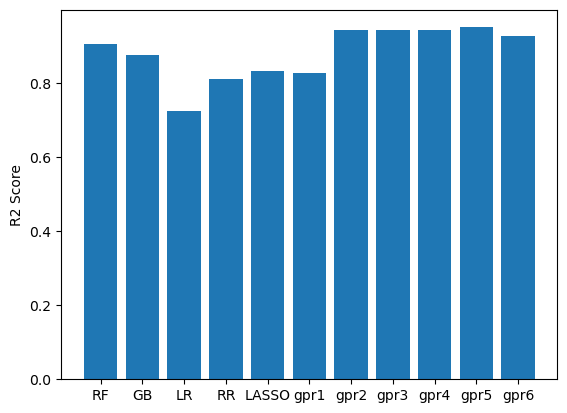

In [32]:
run_models()

In [33]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA', 'X_IEII', 'B_Hf',
       'std_A2X', 'A_ChiP', 'std_B2X', 'X_G', 'B_MP', 'OF', 'B_Ra',
       'A_MP'], dtype=object)

In [34]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8919889568485031
RMSE:  0.08872590602922598
---------------------------------------
GB
R2:  0.8195437269924835
RMSE:  0.11468387387339712
---------------------------------------
LR
R2:  0.8325440502777389
RMSE:  0.11047567251230847
---------------------------------------
RR
R2:  0.8514332779140297
RMSE:  0.10405839746548692
---------------------------------------
LASSO
R2:  0.8161442160571082
RMSE:  0.11575906522436968
---------------------------------------
gpr1
R2:  0.8764297011734098
RMSE:  0.09490157303432108
---------------------------------------
gpr2
R2:  0.9245661359060131
RMSE:  0.07414801688137257
---------------------------------------
gpr3
R2:  0.8923345266627749
RMSE:  0.0885838577838431
---------------------------------------
gpr4
R2:  0.8923345287220603
RMSE:  0.08858385693668461
---------------------------------------
gpr5
R2:  0.9304056198127306
RMSE:  0.07122024253725918
---------------------------------------
gpr6
R2:  0.9350406623394413
RMSE:  0.0688077183

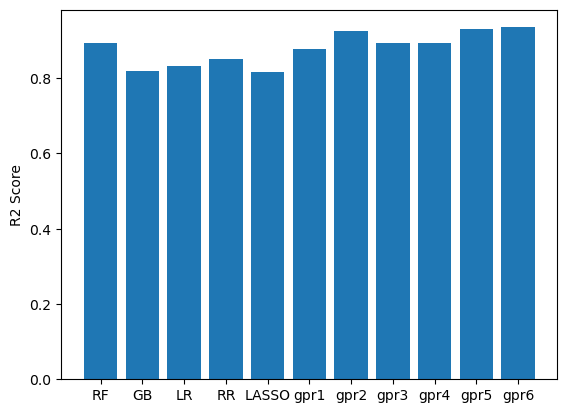

In [35]:
run_models()

In [36]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'X_EA', 'X_Z', 'X_Rvdw', 'mean_X2X', 'A_Rvdw',
       'mean_A2X', 'A_IEI', 'E_coh', 'A_ChiA'], dtype=object)

In [37]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8968372947973969
RMSE:  0.08671170457203832
---------------------------------------
GB
R2:  0.7991684068752161
RMSE:  0.12098523693450199
---------------------------------------
LR
R2:  0.8367154726986699
RMSE:  0.10909098907427724
---------------------------------------
RR
R2:  0.8411398777574848
RMSE:  0.10760285855151258
---------------------------------------
LASSO
R2:  0.81676762742244
RMSE:  0.11556264280750433
---------------------------------------
gpr1
R2:  0.8464117069681806
RMSE:  0.10580237569658454
---------------------------------------
gpr2
R2:  0.857969199928738
RMSE:  0.10174372396462383
---------------------------------------
gpr3
R2:  0.8065272944042572
RMSE:  0.11874797576393041
---------------------------------------
gpr4
R2:  0.8065273604765417
RMSE:  0.11874795548729582
---------------------------------------
gpr5
R2:  0.881535030413896
RMSE:  0.09292045682999445
---------------------------------------
gpr6
R2:  0.8809505057852013
RMSE:  0.0931494167567

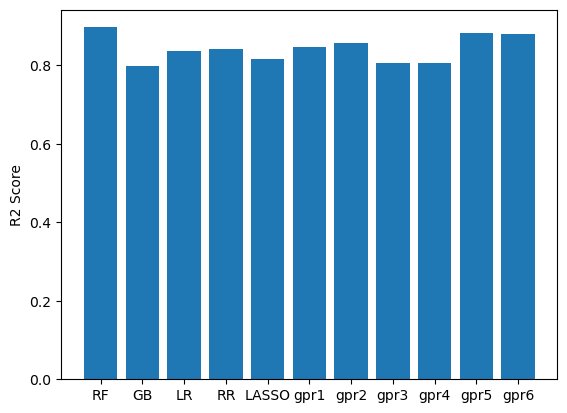

In [38]:
run_models()